In [1]:
import pandas as pd

# Load the dataset 
dataset_path = "preprocessed_indoor_data.csv"  # actual file path
df = pd.read_csv(dataset_path)

# Displayed first few rows
print("Before Renaming the column in the dataset")
df.head()

Before Renaming the column in the dataset


,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7
0,2024-04-06 12:00:27+05:30,1256,163,42.0,33.8,49.0,520.0,18.0,21.0
1,2024-04-06 12:01:30+05:30,1257,162,37.0,33.8,49.0,637.0,36.0,9.0
2,2024-04-06 12:02:32+05:30,1258,173,47.0,33.7,50.0,679.0,42.0,3.0
3,2024-04-06 12:03:34+05:30,1259,168,37.0,33.3,51.0,539.0,21.0,0.0
4,2024-04-06 12:04:36+05:30,1260,168,37.0,33.3,52.0,697.0,45.0,0.0


In [2]:
#After Renaming the column in the Dataset
# Renamed specific columns (old_name -> new_name)
df.rename(columns={
    "field1": "CO level", 
    "field2": "AQI",
    "field3":"Temperature",
    "field4":"Humidity",
    "field5":"eCO2",
    "field6":"TVOC",
    "field7":"Dust Density"
}, inplace=True)

# Displayed column names after renaming
print("After renaming:")
print(df.columns)


After renaming:
Index(['created_at', 'entry_id', 'CO level', 'AQI', 'Temperature', 'Humidity',
       'eCO2', 'TVOC', 'Dust Density'],
      dtype='object')


In [3]:
!pip install pmdarima
!pip install statsmodels


Training ARIMA Model for AQI Prediction

In [4]:
#Import dependencies
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [5]:
#Converted Time Column to DateTime Format
# Ensured 'created_at' is in datetime format

df['created_at'] = pd.to_datetime(df['created_at'])
df.set_index('created_at', inplace=True)

# Sort by date (important for time-series modeling)
df = df.sort_index()


In [6]:
#Select AQI Column for Forecasting
# Selecting AQI column for prediction 

aqi_column = 'AQI'  
data = df[aqi_column]

# CheckAing for missing values
data = data.ffill()  # Forwarded-fill missing values
print(data)


created_at
2024-04-06 12:00:27+05:30    42.0
2024-04-06 12:01:30+05:30    37.0
2024-04-06 12:02:32+05:30    47.0
2024-04-06 12:03:34+05:30    37.0
2024-04-06 12:04:36+05:30    37.0
                             ... 
2024-04-07 11:54:43+05:30    46.0
2024-04-07 11:55:45+05:30    40.0
2024-04-07 11:56:47+05:30    39.0
2024-04-07 11:58:44+05:30    43.0
2024-04-07 11:59:46+05:30    39.0
Name: AQI, Length: 1333, dtype: float64


In [16]:
#Training the ARIMA Model
# Train ARIMA Model (adjust order based on dataset behavior)
model = ARIMA(data, order=(5, 1, 0))  # (p,d,q) values can be tuned
model_fit = model.fit()

# Display summary of model
print(model_fit.summary())
df["Predicted_AQI"] = model_fit.predict(start=1, end=len(df), dynamic=False)


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


PREDICTED AIR QUALITY INDEX (AQI)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


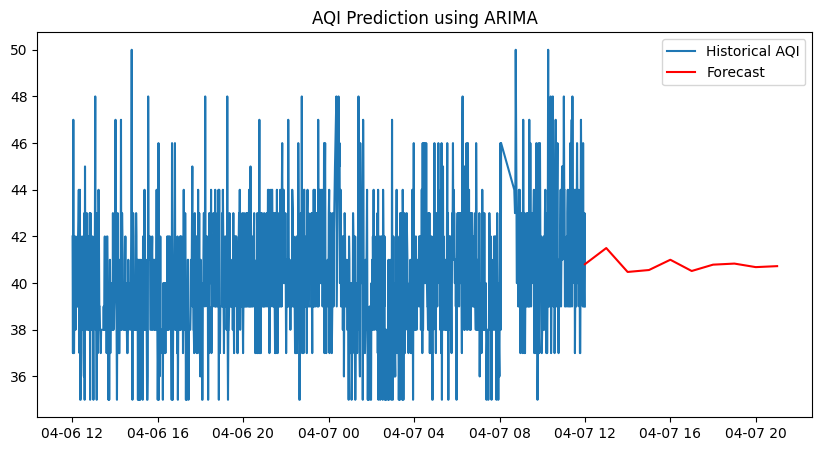

In [8]:
#Predicting AQI Values
# Predicting next 10 time points
predicted = model_fit.forecast(steps=10)
print(predicted)

# Plot the Predicted values
plt.figure(figsize=(10,5))
plt.plot(data, label="Historical AQI")
plt.plot(pd.date_range(data.index[-1], periods=10, freq='H'), predicted, label="Forecast", color='red')
plt.legend()
plt.title("AQI Prediction using ARIMA")
plt.show()


Detect Anomalies in AQI Data

In [9]:
from scipy.stats import zscore

# Computed Z-score for anomaly detection
df['z_score'] = zscore(df[aqi_column])

# Defined threshold (e.g., Z-score above 3 or below -3)
threshold = 3
df['anomaly'] = df['z_score'].apply(lambda x: 1 if abs(x) > threshold else 0)


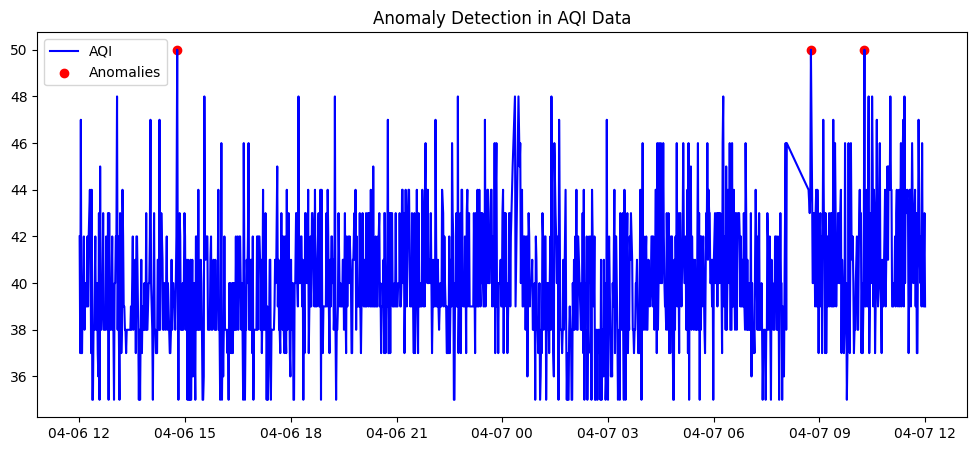

In [10]:
#Visualizing Anomalies

plt.figure(figsize=(12,5))
plt.plot(df.index, df[aqi_column], label="AQI", color="blue")
plt.scatter(df[df['anomaly'] == 1].index, df[df['anomaly'] == 1][aqi_column], color="red", label="Anomalies")
plt.legend()
plt.title("Anomaly Detection in AQI Data")
plt.show()


GENERATING MODEL EVALUATING RESULT

In [11]:
# Saving predicted and anomaly detection
df.to_csv("aqi_results.csv", index=True)

print("Results saved successfully!")

Results saved successfully!


RE-TRAINING ARIMA MODEL - AFTER ANOMALY REMOVAL

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


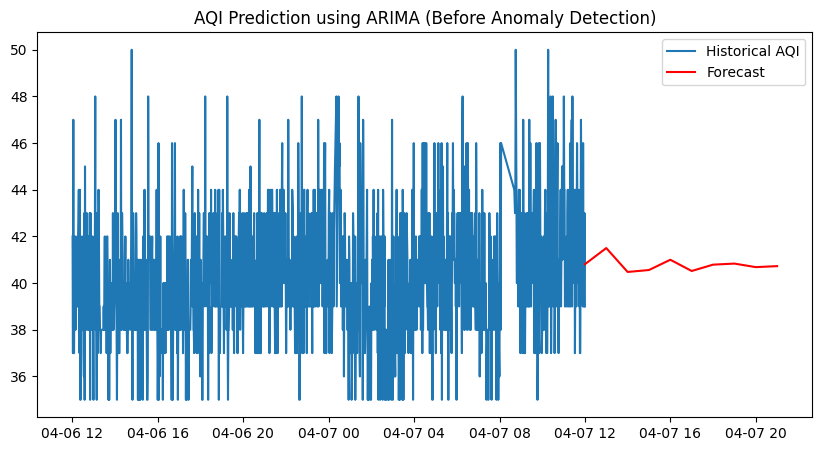

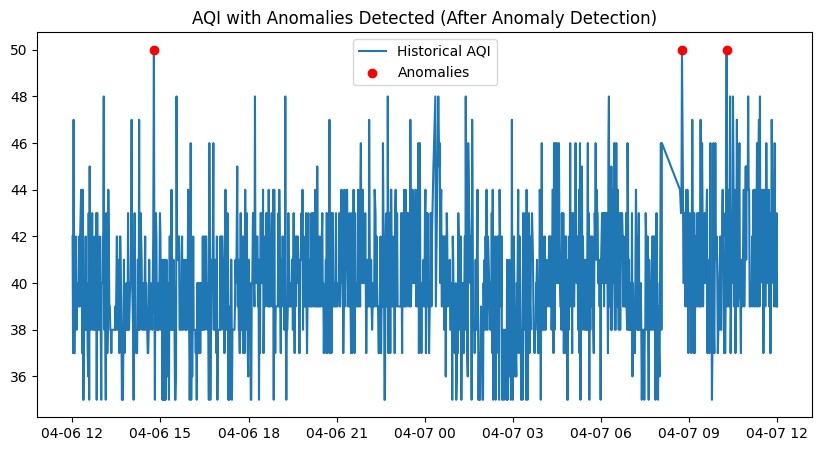

Anomalies Detected: 3


In [12]:
# Predicting AQI Values (Before Anomaly Detection)
predicted = model_fit.forecast(steps=10)
print(predicted)

# Plot the predicted values (Before Anomaly Detection)
plt.figure(figsize=(10,5))
plt.plot(data, label="Historical AQI")
plt.plot(pd.date_range(data.index[-1], periods=10, freq='H'), predicted, label="Forecast", color='red')
plt.legend()
plt.title("AQI Prediction using ARIMA (Before Anomaly Detection)")
plt.show()

# Anomaly Detection (After Anomaly Detection)
from scipy.stats import zscore

# Compute Z-score for anomaly detection
df['z_score'] = zscore(df[aqi_column])

# Define threshold (e.g., Z-score above 3 or below -3)
threshold = 3
df['anomaly'] = df['z_score'].apply(lambda x: 1 if abs(x) > threshold else 0)

# Plotting the anomalies (After Anomaly Detection)
plt.figure(figsize=(10,5))
plt.plot(df.index, df[aqi_column], label="Historical AQI")
plt.scatter(df.index[df['anomaly'] == 1], df[aqi_column][df['anomaly'] == 1], color='red', label='Anomalies', zorder=5)
plt.legend()
plt.title("AQI with Anomalies Detected (After Anomaly Detection)")
plt.show()

# Compare Results
# Before anomaly detection, you have the ARIMA predicted values, while after anomaly detection, anomalies are flagged.
print("Anomalies Detected:", df['anomaly'].sum())


COMPARING MODEL BEFORE AND AFTER ANOMALY REMOVAL - aqi values (with mean_absolute_error, mean_squared_error, r2_score)
because these are standard error metrics used in regression and forecasting tasks to evaluate the quality of a predictive model

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Actual AQI values for the next 10 time points (Assume this is available)
actual_aqi = df['AQI'].iloc[-10:].values  # Replace with actual AQI values

# Predictions before anomaly removal
pred_before = predicted_df['predicted_AQI'].values

# Predictions after anomaly removal (fill NaNs with interpolated values)
pred_after = cleaned_predicted_df['predicted_AQI'].reindex(predicted_df.index).interpolate().values

# Compute error metrics before anomaly removal
mae_before = mean_absolute_error(actual_aqi, pred_before)
mse_before = mean_squared_error(actual_aqi, pred_before)
r2_before = r2_score(actual_aqi, pred_before)

# Compute error metrics after anomaly removal
mae_after = mean_absolute_error(actual_aqi, pred_after)
mse_after = mean_squared_error(actual_aqi, pred_after)
r2_after = r2_score(actual_aqi, pred_after)

# Display results
print(f"Before Anomaly Removal: MAE = {mae_before:.4f}, MSE = {mse_before:.4f}, R2 Score = {r2_before:.4f}")
print(f"After Anomaly Removal: MAE = {mae_after:.4f}, MSE = {mse_after:.4f}, R2 Score = {r2_after:.4f}")


NameError: name 'predicted_df' is not defined